## Import

In [7]:
# importing the libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
from itertools import chain

# for reading and displaying images
# from skimage.io import imread
import matplotlib.pyplot as plt
from glob import glob

# for creating validation set
from sklearn.model_selection import train_test_split

# PyTorch libraries and modules
import torch
import torch.nn as nn
import torch.nn.functional as F

# models
from src.architectures.resnet import *
from src.architectures.levakov_96 import *
from src.architectures.inception import *
from src.architectures.dinsdale import *

# other files
from src.run import *

# Torch
from torch.optim import *
import torch.optim as optim
from torchsummary import summary
from tensorboardX import SummaryWriter

# CAM - M3dCam
from medcam import medcam

## Dataloader
for kFold, it will be run again on the run

In [8]:
from src.dataloader import *

train_dset = MyDataset(task_type='age')
test_dset = MyDataset(task_type='age', test=True)

train_loader = DataLoader(train_dset, batch_size=8)
test_loader = DataLoader(test_dset, batch_size=8)

## Load Model

In [9]:
def load_model(model, verbose=True):
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Model {model.capitalize()} is selected.')

    if model == 'resnet':
        

        opt = Option()
        model = generate_model(model_depth=opt.model_depth,
                                    n_classes=opt.n_classes,
                                    n_input_channels=opt.n_input_channels,
                                    shortcut_type=opt.shortcut_type,
                                    conv1_t_size=opt.conv1_t_size,
                                    conv1_t_stride=opt.conv1_t_stride,
                                    no_max_pool=opt.no_max_pool,
                                    widen_factor=opt.resnet_widen_factor)

    elif model == 'levakov':
        model = Levakov(task_type='age')

    elif model == 'inception':
        model = Inception3()

    elif model == 'dinsdale':
        model = Dinsdale(1, 1, 2)

    else: return None

    model.to(device)
    if verbose:
        print(summary(model, input_size=(1, 96, 96, 96)))
    
    return model, device

model = 'resnet'
model, device = load_model(model)
# model = medcam.inject(model, output_dir="attention_maps", save_maps=True)

Model Resnet is selected.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 16, 96, 48, 48]           2,352
       BatchNorm3d-2       [-1, 16, 96, 48, 48]              32
              ReLU-3       [-1, 16, 96, 48, 48]               0
         MaxPool3d-4       [-1, 16, 48, 24, 24]               0
            Conv3d-5       [-1, 16, 48, 24, 24]           6,912
       BatchNorm3d-6       [-1, 16, 48, 24, 24]              32
              ReLU-7       [-1, 16, 48, 24, 24]               0
            Conv3d-8       [-1, 16, 48, 24, 24]           6,912
       BatchNorm3d-9       [-1, 16, 48, 24, 24]              32
             ReLU-10       [-1, 16, 48, 24, 24]               0
       BasicBlock-11       [-1, 16, 48, 24, 24]               0
           Conv3d-12       [-1, 32, 24, 12, 12]          13,824
      BatchNorm3d-13       [-1, 32, 24, 12, 12]              64
             

## Setups

Default Settings

In [10]:
task_type = 'age' # no longer used.
resize = True
scheduler = False
epochs = range(100)
folds = range(10)

Loss & Optimizer

In [11]:
from src.losses import RMSELoss

loss_fn = nn.MSELoss()
lamb = 0.0005
# optimizer = optim.Adam(model.parameters(), lr=1e-4)

Metrics

In [12]:
rmse_fn = RMSELoss()
mae_fn = nn.L1Loss()

## Run

### without Folds

Model Resnet is selected.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 16, 96, 48, 48]           2,352
       BatchNorm3d-2       [-1, 16, 96, 48, 48]              32
              ReLU-3       [-1, 16, 96, 48, 48]               0
         MaxPool3d-4       [-1, 16, 48, 24, 24]               0
            Conv3d-5       [-1, 16, 48, 24, 24]           6,912
       BatchNorm3d-6       [-1, 16, 48, 24, 24]              32
              ReLU-7       [-1, 16, 48, 24, 24]               0
            Conv3d-8       [-1, 16, 48, 24, 24]           6,912
       BatchNorm3d-9       [-1, 16, 48, 24, 24]              32
             ReLU-10       [-1, 16, 48, 24, 24]               0
       BasicBlock-11       [-1, 16, 48, 24, 24]               0
           Conv3d-12       [-1, 32, 24, 12, 12]          13,824
      BatchNorm3d-13       [-1, 32, 24, 12, 12]              64
             

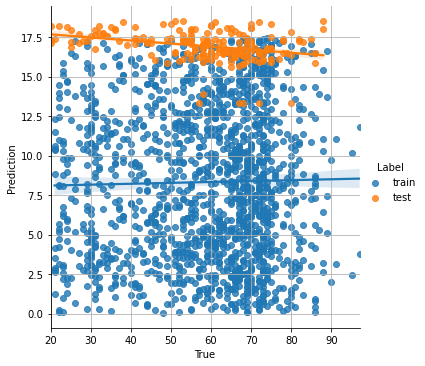

MSE  :: [TRAIN] 3207.923 | [VALID] 1946.020
RMSE :: [TRAIN] 54.180  | [VALID] 41.179
CORR :: [TRAIN] 0.019 | [VALID] -0.316

WorkingTime[train]: 160.3748767375946 sec
WorkingTime[train]: 791.3717095851898 sec
WorkingTime[eval]: 34.69545221328735 sec
WorkingTime[make_df]: 0.001999378204345703 sec
WorkingTime[make_df]: 0.0019998550415039062 sec
WorkingTime[make_df]: 0.0010006427764892578 sec
FOLD None - EPOCHS 1
MAE  :: [TRAIN] 36.025   | [TEST] 24.102
WorkingTime[train]: 156.88457131385803 sec
WorkingTime[train]: 754.8253018856049 sec
WorkingTime[eval]: 30.685729026794434 sec
WorkingTime[make_df]: 0.002001523971557617 sec
WorkingTime[make_df]: 0.001999378204345703 sec
WorkingTime[make_df]: 0.0010001659393310547 sec
FOLD None - EPOCHS 2
MAE  :: [TRAIN] 20.755   | [TEST] 15.341
WorkingTime[train]: 148.82256698608398 sec
WorkingTime[train]: 754.6298038959503 sec
WorkingTime[eval]: 29.32031011581421 sec
WorkingTime[make_df]: 0.002000570297241211 sec
WorkingTime[make_df]: 0.00199818611145019

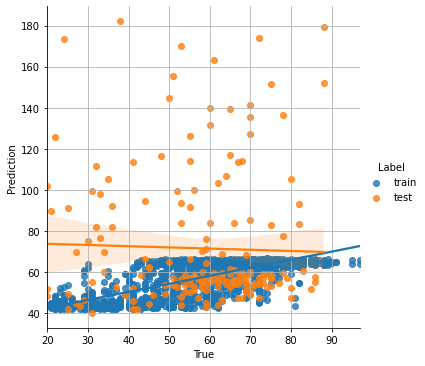

MSE  :: [TRAIN] 146.106 | [VALID] 1447.049
RMSE :: [TRAIN] 10.041  | [VALID] 25.367
CORR :: [TRAIN] 0.738 | [VALID] -0.029

WorkingTime[train]: 148.82217144966125 sec
WorkingTime[train]: 764.3499660491943 sec
WorkingTime[eval]: 30.283284187316895 sec
WorkingTime[make_df]: 0.0019996166229248047 sec
WorkingTime[make_df]: 0.002000093460083008 sec
WorkingTime[make_df]: 0.0 sec
FOLD None - EPOCHS 6
MAE  :: [TRAIN] 9.261   | [TEST] 23.423
WorkingTime[train]: 149.5643594264984 sec
WorkingTime[train]: 768.3663744926453 sec
WorkingTime[eval]: 29.223328828811646 sec
WorkingTime[make_df]: 0.0020003318786621094 sec
WorkingTime[make_df]: 0.002000570297241211 sec
WorkingTime[make_df]: 0.0 sec
FOLD None - EPOCHS 7
MAE  :: [TRAIN] 8.979   | [TEST] 20.491
WorkingTime[train]: 149.62568163871765 sec
WorkingTime[train]: 763.184980392456 sec
WorkingTime[eval]: 30.30691695213318 sec
WorkingTime[make_df]: 0.0010006427764892578 sec
WorkingTime[make_df]: 0.0010001659393310547 sec
WorkingTime[make_df]: 0.000999

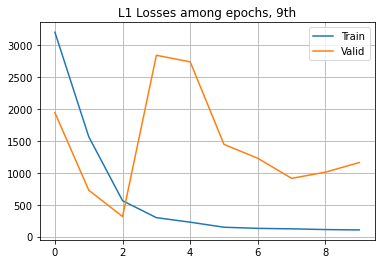

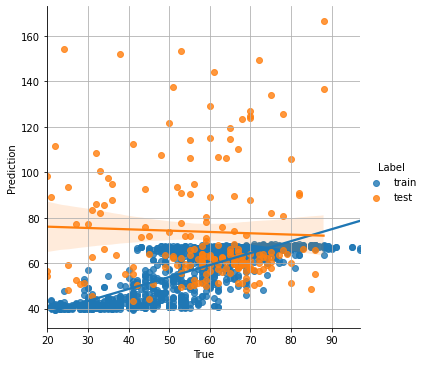

WorkingTime[train]: 150.03770518302917 sec
WorkingTime[train]: 767.749395608902 sec
WorkingTime[eval]: 29.414793252944946 sec
WorkingTime[make_df]: 0.0010001659393310547 sec
WorkingTime[make_df]: 0.0009996891021728516 sec
WorkingTime[make_df]: 0.0009999275207519531 sec
FOLD None - EPOCHS 10
MAE  :: [TRAIN] 7.968   | [TEST] 25.349


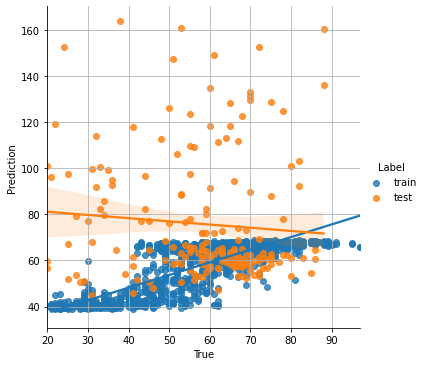

MSE  :: [TRAIN] 96.830 | [VALID] 1333.074
RMSE :: [TRAIN] 7.968  | [VALID] 25.349
CORR :: [TRAIN] 0.842 | [VALID] -0.081

WorkingTime[train]: 148.89077258110046 sec
WorkingTime[train]: 767.5489568710327 sec
WorkingTime[eval]: 30.923612356185913 sec
WorkingTime[make_df]: 0.0019998550415039062 sec
WorkingTime[make_df]: 0.0009996891021728516 sec
WorkingTime[make_df]: 0.0009996891021728516 sec
FOLD None - EPOCHS 11
MAE  :: [TRAIN] 7.844   | [TEST] 21.664
WorkingTime[train]: 149.13991022109985 sec
WorkingTime[train]: 765.4956469535828 sec
WorkingTime[eval]: 29.25037455558777 sec
WorkingTime[make_df]: 0.0019991397857666016 sec
WorkingTime[make_df]: 0.0019989013671875 sec
WorkingTime[make_df]: 0.0010008811950683594 sec
FOLD None - EPOCHS 12
MAE  :: [TRAIN] 7.568   | [TEST] 21.758
WorkingTime[train]: 147.8448097705841 sec
WorkingTime[train]: 752.1832988262177 sec
WorkingTime[eval]: 30.317909002304077 sec
WorkingTime[make_df]: 0.0010001659393310547 sec
WorkingTime[make_df]: 0.00099945068359375 

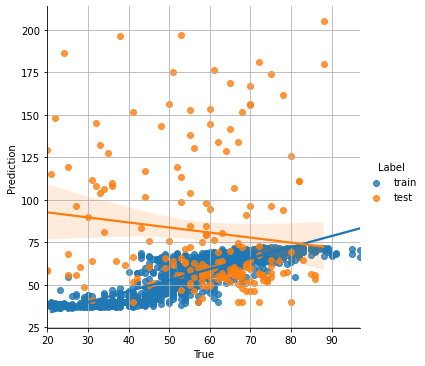

MSE  :: [TRAIN] 75.297 | [VALID] 2466.134
RMSE :: [TRAIN] 6.853  | [VALID] 33.987
CORR :: [TRAIN] 0.897 | [VALID] -0.117

WorkingTime[train]: 149.50272583961487 sec
WorkingTime[train]: 769.480771780014 sec
WorkingTime[eval]: 29.643978595733643 sec
WorkingTime[make_df]: 0.0020012855529785156 sec
WorkingTime[make_df]: 0.0019996166229248047 sec
WorkingTime[make_df]: 0.0010001659393310547 sec
FOLD None - EPOCHS 16
MAE  :: [TRAIN] 6.635   | [TEST] 27.678
WorkingTime[train]: 148.56754517555237 sec
WorkingTime[train]: 767.463136434555 sec
WorkingTime[eval]: 29.861631870269775 sec
WorkingTime[make_df]: 0.0020017623901367188 sec
WorkingTime[make_df]: 0.0019991397857666016 sec
WorkingTime[make_df]: 0.0010004043579101562 sec
FOLD None - EPOCHS 17
MAE  :: [TRAIN] 6.603   | [TEST] 32.604
WorkingTime[train]: 147.93393635749817 sec
WorkingTime[train]: 766.3205940723419 sec
WorkingTime[eval]: 28.971665859222412 sec
WorkingTime[make_df]: 0.0010004043579101562 sec
WorkingTime[make_df]: 0.000998497009277

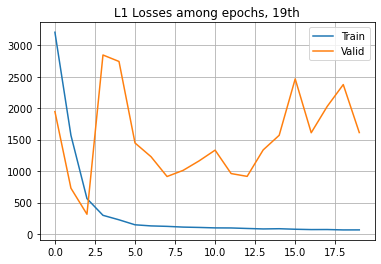

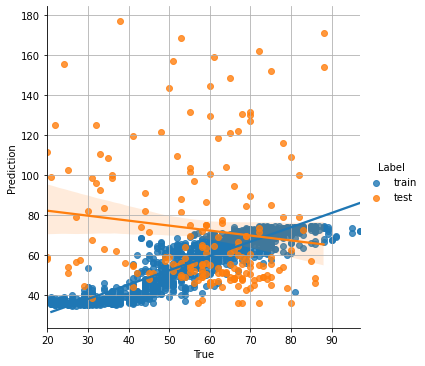

WorkingTime[train]: 150.17828559875488 sec
WorkingTime[train]: 762.1413238048553 sec
WorkingTime[eval]: 29.178977727890015 sec
WorkingTime[make_df]: 0.0009996891021728516 sec
WorkingTime[make_df]: 0.0010004043579101562 sec
WorkingTime[make_df]: 0.00099945068359375 sec
FOLD None - EPOCHS 20
MAE  :: [TRAIN] 6.084   | [TEST] 32.678


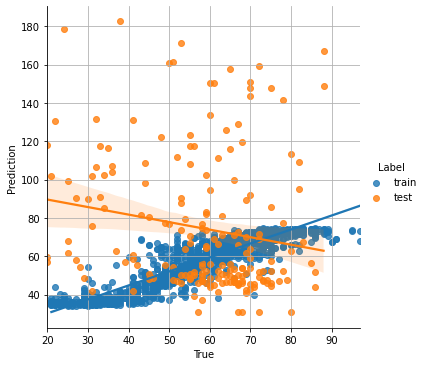

MSE  :: [TRAIN] 62.958 | [VALID] 1946.841
RMSE :: [TRAIN] 6.084  | [VALID] 32.678
CORR :: [TRAIN] 0.921 | [VALID] -0.173

WorkingTime[train]: 152.24400067329407 sec
WorkingTime[train]: 767.6669805049896 sec
WorkingTime[eval]: 30.061803817749023 sec
WorkingTime[make_df]: 0.002000570297241211 sec
WorkingTime[make_df]: 0.001998424530029297 sec
WorkingTime[make_df]: 0.0 sec
FOLD None - EPOCHS 21
MAE  :: [TRAIN] 5.939   | [TEST] 29.061
WorkingTime[train]: 148.67694282531738 sec
WorkingTime[train]: 767.1548194885254 sec
WorkingTime[eval]: 30.333605766296387 sec
WorkingTime[make_df]: 0.0020008087158203125 sec
WorkingTime[make_df]: 0.002001047134399414 sec
WorkingTime[make_df]: 0.0009980201721191406 sec
FOLD None - EPOCHS 22
MAE  :: [TRAIN] 5.679   | [TEST] 26.446
WorkingTime[train]: 150.36359858512878 sec
WorkingTime[train]: 767.0455613136292 sec
WorkingTime[eval]: 31.047127962112427 sec
WorkingTime[make_df]: 0.0010004043579101562 sec
WorkingTime[make_df]: 0.0010006427764892578 sec
WorkingTim

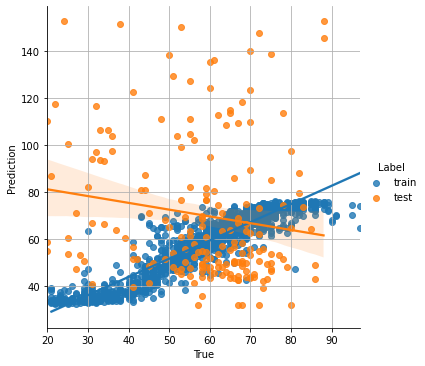

MSE  :: [TRAIN] 52.697 | [VALID] 1402.763
RMSE :: [TRAIN] 5.404  | [VALID] 28.177
CORR :: [TRAIN] 0.933 | [VALID] -0.151

WorkingTime[train]: 150.71101427078247 sec
WorkingTime[train]: 765.4379463195801 sec
WorkingTime[eval]: 29.56083607673645 sec
WorkingTime[make_df]: 0.002000570297241211 sec
WorkingTime[make_df]: 0.0019991397857666016 sec
WorkingTime[make_df]: 0.0009999275207519531 sec
FOLD None - EPOCHS 26
MAE  :: [TRAIN] 5.323   | [TEST] 25.649
WorkingTime[train]: 148.19732856750488 sec
WorkingTime[train]: 770.1582686901093 sec
WorkingTime[eval]: 29.86201500892639 sec
WorkingTime[make_df]: 0.0019996166229248047 sec
WorkingTime[make_df]: 0.0019996166229248047 sec
WorkingTime[make_df]: 0.0009992122650146484 sec
FOLD None - EPOCHS 27
MAE  :: [TRAIN] 5.084   | [TEST] 22.566
WorkingTime[train]: 150.51393795013428 sec
WorkingTime[train]: 774.5425469875336 sec
WorkingTime[eval]: 30.964972257614136 sec
WorkingTime[make_df]: 0.0020012855529785156 sec
WorkingTime[make_df]: 0.0019986629486083

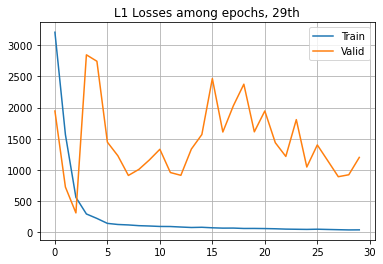

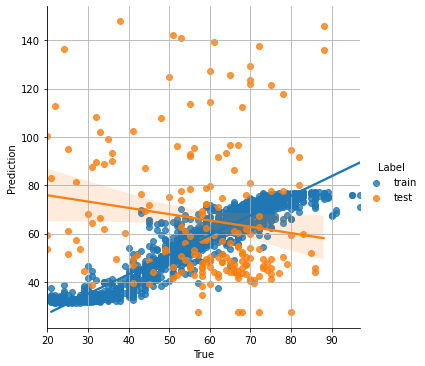

WorkingTime[train]: 148.80343413352966 sec
WorkingTime[train]: 769.777792930603 sec
WorkingTime[eval]: 30.102908611297607 sec
WorkingTime[make_df]: 0.0020020008087158203 sec
WorkingTime[make_df]: 0.0019981861114501953 sec
WorkingTime[make_df]: 0.0010004043579101562 sec
FOLD None - EPOCHS 30
MAE  :: [TRAIN] 4.930   | [TEST] 28.076


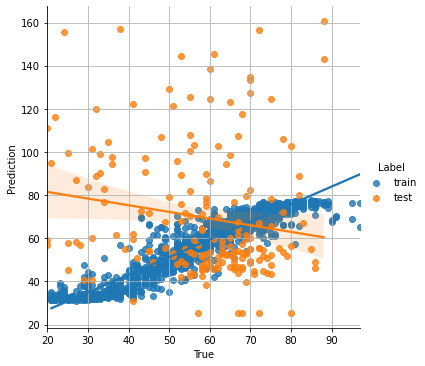

MSE  :: [TRAIN] 43.855 | [VALID] 1395.175
RMSE :: [TRAIN] 4.930  | [VALID] 28.076
CORR :: [TRAIN] 0.944 | [VALID] -0.162

WorkingTime[train]: 150.11707997322083 sec
WorkingTime[train]: 769.6436171531677 sec
WorkingTime[eval]: 28.779968976974487 sec
WorkingTime[make_df]: 0.002001047134399414 sec
WorkingTime[make_df]: 0.0009992122650146484 sec
WorkingTime[make_df]: 0.0 sec
FOLD None - EPOCHS 31
MAE  :: [TRAIN] 4.498   | [TEST] 26.077
WorkingTime[train]: 148.69334387779236 sec
WorkingTime[train]: 771.792679309845 sec
WorkingTime[eval]: 30.714784622192383 sec
WorkingTime[make_df]: 0.0019986629486083984 sec
WorkingTime[make_df]: 0.001999378204345703 sec
WorkingTime[make_df]: 0.0009999275207519531 sec
FOLD None - EPOCHS 32
MAE  :: [TRAIN] 4.739   | [TEST] 27.858
WorkingTime[train]: 149.65414834022522 sec
WorkingTime[train]: 771.9651174545288 sec
WorkingTime[eval]: 30.567185878753662 sec
WorkingTime[make_df]: 0.0020003318786621094 sec
WorkingTime[make_df]: 0.0019998550415039062 sec
WorkingTim

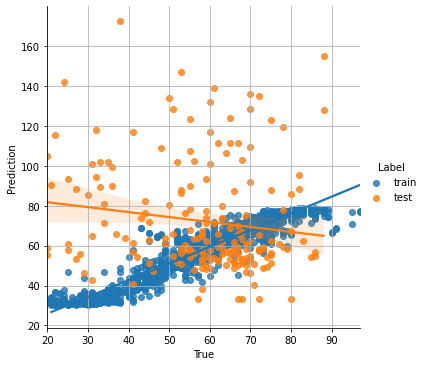

MSE  :: [TRAIN] 38.750 | [VALID] 1289.284
RMSE :: [TRAIN] 4.598  | [VALID] 26.160
CORR :: [TRAIN] 0.951 | [VALID] -0.142

WorkingTime[train]: 149.3115680217743 sec
WorkingTime[train]: 765.3193025588989 sec
WorkingTime[eval]: 29.096375226974487 sec
WorkingTime[make_df]: 0.0019991397857666016 sec
WorkingTime[make_df]: 0.001999378204345703 sec
WorkingTime[make_df]: 0.0009996891021728516 sec
FOLD None - EPOCHS 36
MAE  :: [TRAIN] 4.489   | [TEST] 26.918
WorkingTime[train]: 149.84843277931213 sec
WorkingTime[train]: 764.9582080841064 sec
WorkingTime[eval]: 28.953999042510986 sec
WorkingTime[make_df]: 0.0010001659393310547 sec
WorkingTime[make_df]: 0.0009996891021728516 sec
WorkingTime[make_df]: 0.0 sec
FOLD None - EPOCHS 37
MAE  :: [TRAIN] 4.462   | [TEST] 29.767
WorkingTime[train]: 150.74055457115173 sec
WorkingTime[train]: 763.7835705280304 sec
WorkingTime[eval]: 28.95740032196045 sec
WorkingTime[make_df]: 0.002001047134399414 sec
WorkingTime[make_df]: 0.0009992122650146484 sec
WorkingTime

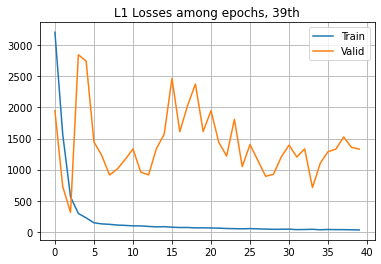

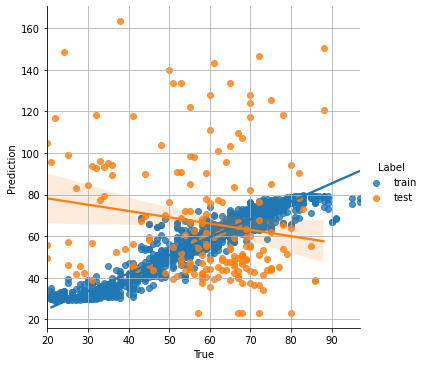

WorkingTime[train]: 149.36158680915833 sec
WorkingTime[train]: 763.9539868831635 sec
WorkingTime[eval]: 29.413028717041016 sec
WorkingTime[make_df]: 0.0010008811950683594 sec
WorkingTime[make_df]: 0.0009996891021728516 sec
WorkingTime[make_df]: 0.0010001659393310547 sec
FOLD None - EPOCHS 40
MAE  :: [TRAIN] 4.246   | [TEST] 30.365


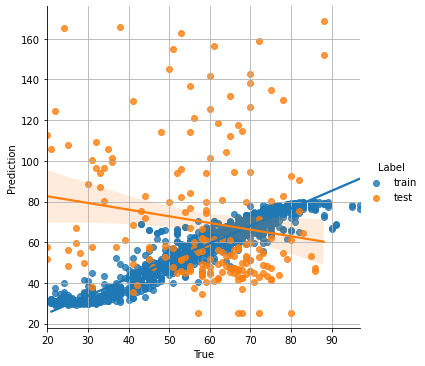

MSE  :: [TRAIN] 32.925 | [VALID] 1643.646
RMSE :: [TRAIN] 4.246  | [VALID] 30.365
CORR :: [TRAIN] 0.958 | [VALID] -0.153

WorkingTime[train]: 150.7606680393219 sec
WorkingTime[train]: 768.7075102329254 sec
WorkingTime[eval]: 30.23283338546753 sec
WorkingTime[make_df]: 0.0019989013671875 sec
WorkingTime[make_df]: 0.0019998550415039062 sec
WorkingTime[make_df]: 0.0 sec
FOLD None - EPOCHS 41
MAE  :: [TRAIN] 4.332   | [TEST] 29.171
WorkingTime[train]: 150.63223719596863 sec
WorkingTime[train]: 762.4437453746796 sec
WorkingTime[eval]: 29.76138210296631 sec
WorkingTime[make_df]: 0.002001047134399414 sec
WorkingTime[make_df]: 0.0019989013671875 sec
WorkingTime[make_df]: 0.0010013580322265625 sec
FOLD None - EPOCHS 42
MAE  :: [TRAIN] 4.164   | [TEST] 28.314
WorkingTime[train]: 149.83096528053284 sec
WorkingTime[train]: 753.379665851593 sec
WorkingTime[eval]: 29.351963758468628 sec
WorkingTime[make_df]: 0.0020008087158203125 sec
WorkingTime[make_df]: 0.002000570297241211 sec
WorkingTime[make_df

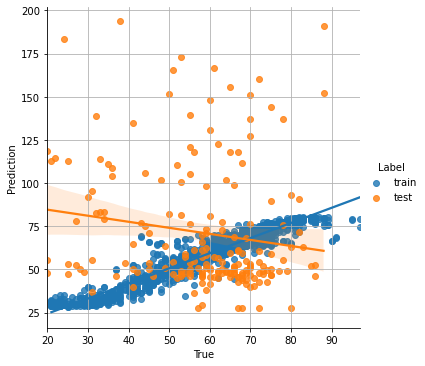

MSE  :: [TRAIN] 29.723 | [VALID] 1877.242
RMSE :: [TRAIN] 4.018  | [VALID] 31.215
CORR :: [TRAIN] 0.962 | [VALID] -0.151

WorkingTime[train]: 149.02322721481323 sec
WorkingTime[train]: 769.447762966156 sec
WorkingTime[eval]: 29.143908739089966 sec
WorkingTime[make_df]: 0.001997232437133789 sec
WorkingTime[make_df]: 0.0019986629486083984 sec
WorkingTime[make_df]: 0.0010001659393310547 sec
FOLD None - EPOCHS 46
MAE  :: [TRAIN] 3.749   | [TEST] 31.700
WorkingTime[train]: 150.28573203086853 sec
WorkingTime[train]: 770.7799732685089 sec
WorkingTime[eval]: 29.827942371368408 sec
WorkingTime[make_df]: 0.002000570297241211 sec
WorkingTime[make_df]: 0.001999378204345703 sec
WorkingTime[make_df]: 0.0010001659393310547 sec
FOLD None - EPOCHS 47
MAE  :: [TRAIN] 3.899   | [TEST] 28.821
WorkingTime[train]: 150.40750932693481 sec
WorkingTime[train]: 763.1338806152344 sec
WorkingTime[eval]: 29.926056146621704 sec
WorkingTime[make_df]: 0.0020003318786621094 sec
WorkingTime[make_df]: 0.00199961662292480

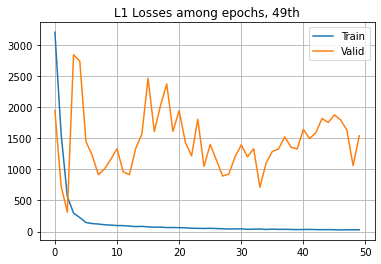

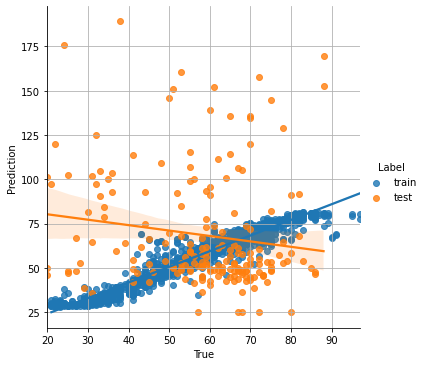

WorkingTime[train]: 149.5549988746643 sec
WorkingTime[train]: 768.244754076004 sec
WorkingTime[eval]: 30.179908514022827 sec
WorkingTime[make_df]: 0.001997709274291992 sec
WorkingTime[make_df]: 0.0010018348693847656 sec
WorkingTime[make_df]: 0.001001119613647461 sec
FOLD None - EPOCHS 50
MAE  :: [TRAIN] 3.991   | [TEST] 28.989


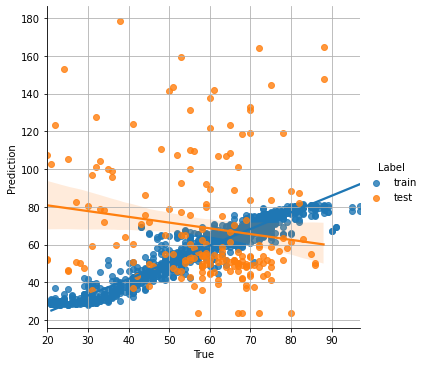

MSE  :: [TRAIN] 29.541 | [VALID] 1525.051
RMSE :: [TRAIN] 3.991  | [VALID] 28.989
CORR :: [TRAIN] 0.962 | [VALID] -0.148

WorkingTime[train]: 150.65577578544617 sec
WorkingTime[train]: 771.0568134784698 sec
WorkingTime[eval]: 28.93477439880371 sec
WorkingTime[make_df]: 0.0020003318786621094 sec
WorkingTime[make_df]: 0.0019989013671875 sec
WorkingTime[make_df]: 0.0 sec
FOLD None - EPOCHS 51
MAE  :: [TRAIN] 3.834   | [TEST] 31.179
WorkingTime[train]: 150.42272996902466 sec
WorkingTime[train]: 765.4194438457489 sec
WorkingTime[eval]: 30.42925453186035 sec
WorkingTime[make_df]: 0.002000570297241211 sec
WorkingTime[make_df]: 0.0019996166229248047 sec
WorkingTime[make_df]: 0.0009999275207519531 sec
FOLD None - EPOCHS 52
MAE  :: [TRAIN] 3.902   | [TEST] 29.413
WorkingTime[train]: 150.76136684417725 sec
WorkingTime[train]: 764.991973400116 sec
WorkingTime[eval]: 29.193283081054688 sec
WorkingTime[make_df]: 0.002000570297241211 sec
WorkingTime[make_df]: 0.0019986629486083984 sec
WorkingTime[mak

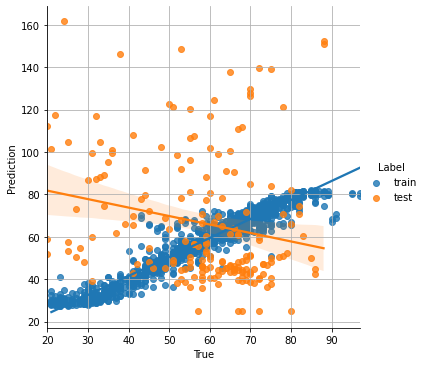

MSE  :: [TRAIN] 25.390 | [VALID] 1406.986
RMSE :: [TRAIN] 3.575  | [VALID] 29.490
CORR :: [TRAIN] 0.967 | [VALID] -0.206

WorkingTime[train]: 149.32230234146118 sec
WorkingTime[train]: 770.2442014217377 sec
WorkingTime[eval]: 29.58594584465027 sec
WorkingTime[make_df]: 0.0010008811950683594 sec
WorkingTime[make_df]: 0.0010008811950683594 sec
WorkingTime[make_df]: 0.00099945068359375 sec
FOLD None - EPOCHS 56
MAE  :: [TRAIN] 3.613   | [TEST] 24.921
WorkingTime[train]: 148.6051366329193 sec
WorkingTime[train]: 772.260493516922 sec
WorkingTime[eval]: 31.0255229473114 sec
WorkingTime[make_df]: 0.002001047134399414 sec
WorkingTime[make_df]: 0.0019998550415039062 sec
WorkingTime[make_df]: 0.0009996891021728516 sec
FOLD None - EPOCHS 57
MAE  :: [TRAIN] 3.532   | [TEST] 22.048
WorkingTime[train]: 149.76587390899658 sec
WorkingTime[train]: 774.0462772846222 sec
WorkingTime[eval]: 29.568368911743164 sec
WorkingTime[make_df]: 0.0019986629486083984 sec
WorkingTime[make_df]: 0.0009996891021728516 s

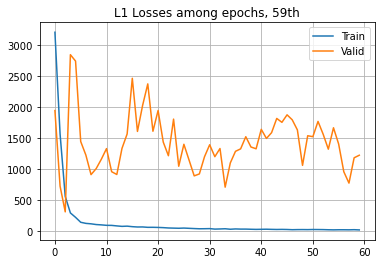

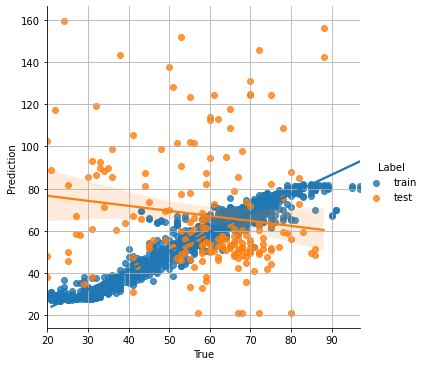

WorkingTime[train]: 149.71959495544434 sec
WorkingTime[train]: 767.5776386260986 sec
WorkingTime[eval]: 30.638861417770386 sec
WorkingTime[make_df]: 0.0019991397857666016 sec
WorkingTime[make_df]: 0.0020003318786621094 sec
WorkingTime[make_df]: 0.0 sec
FOLD None - EPOCHS 60
MAE  :: [TRAIN] 3.341   | [TEST] 27.321


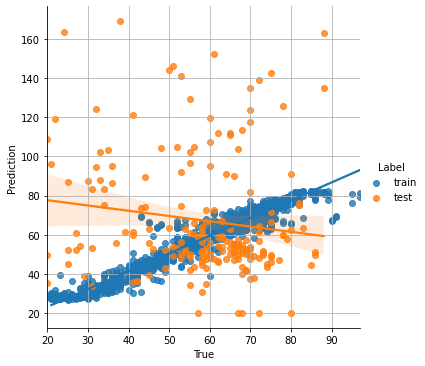

MSE  :: [TRAIN] 22.222 | [VALID] 1381.579
RMSE :: [TRAIN] 3.341  | [VALID] 27.321
CORR :: [TRAIN] 0.971 | [VALID] -0.137

WorkingTime[train]: 148.49922680854797 sec
WorkingTime[train]: 752.3213806152344 sec
WorkingTime[eval]: 29.301740169525146 sec
WorkingTime[make_df]: 0.001999378204345703 sec
WorkingTime[make_df]: 0.002000093460083008 sec
WorkingTime[make_df]: 0.0009999275207519531 sec
FOLD None - EPOCHS 61
MAE  :: [TRAIN] 3.452   | [TEST] 23.075
WorkingTime[train]: 150.62259602546692 sec
WorkingTime[train]: 758.1550297737122 sec
WorkingTime[eval]: 29.730143308639526 sec
WorkingTime[make_df]: 0.0015175342559814453 sec
WorkingTime[make_df]: 0.001990079879760742 sec
WorkingTime[make_df]: 0.0009987354278564453 sec
FOLD None - EPOCHS 62
MAE  :: [TRAIN] 3.477   | [TEST] 28.489
WorkingTime[train]: 150.50889682769775 sec
WorkingTime[train]: 755.1725609302521 sec
WorkingTime[eval]: 30.872376203536987 sec
WorkingTime[make_df]: 0.002000093460083008 sec
WorkingTime[make_df]: 0.00100064277648925

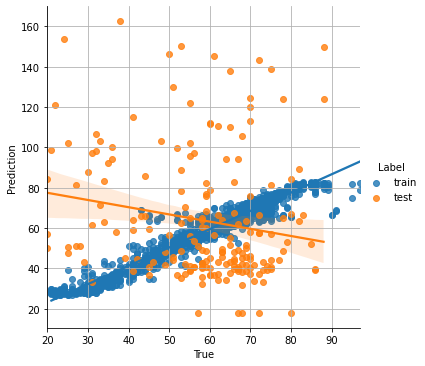

MSE  :: [TRAIN] 22.068 | [VALID] 1418.783
RMSE :: [TRAIN] 3.309  | [VALID] 29.637
CORR :: [TRAIN] 0.971 | [VALID] -0.177

WorkingTime[train]: 150.21948623657227 sec
WorkingTime[train]: 759.6550824642181 sec
WorkingTime[eval]: 30.75376296043396 sec
WorkingTime[make_df]: 0.0019996166229248047 sec
WorkingTime[make_df]: 0.0020012855529785156 sec
WorkingTime[make_df]: 0.0009999275207519531 sec
FOLD None - EPOCHS 66
MAE  :: [TRAIN] 3.263   | [TEST] 27.819
WorkingTime[train]: 151.43698167800903 sec
WorkingTime[train]: 760.9538271427155 sec
WorkingTime[eval]: 30.734237670898438 sec
WorkingTime[make_df]: 0.0010013580322265625 sec
WorkingTime[make_df]: 0.0010008811950683594 sec
WorkingTime[make_df]: 0.0009999275207519531 sec
FOLD None - EPOCHS 67
MAE  :: [TRAIN] 3.410   | [TEST] 28.269
WorkingTime[train]: 149.64655327796936 sec
WorkingTime[train]: 765.7441327571869 sec
WorkingTime[eval]: 29.787421464920044 sec
WorkingTime[make_df]: 0.0019998550415039062 sec
WorkingTime[make_df]: 0.00199913978576

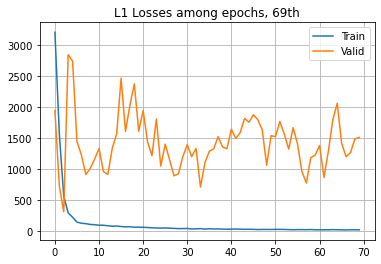

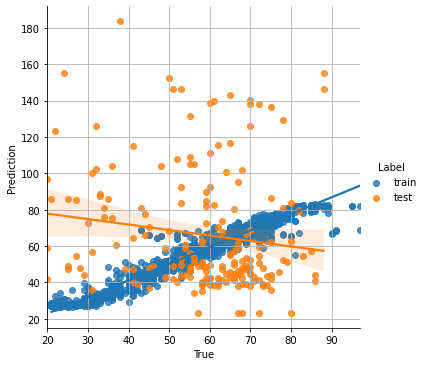

WorkingTime[train]: 148.94457459449768 sec
WorkingTime[train]: 757.8113210201263 sec
WorkingTime[eval]: 30.23212718963623 sec
WorkingTime[make_df]: 0.0020008087158203125 sec
WorkingTime[make_df]: 0.001999378204345703 sec
WorkingTime[make_df]: 0.001001119613647461 sec
FOLD None - EPOCHS 70
MAE  :: [TRAIN] 3.153   | [TEST] 32.895


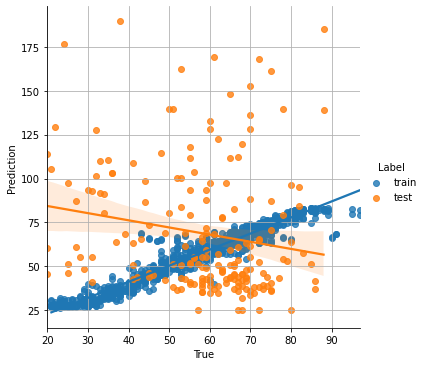

MSE  :: [TRAIN] 20.265 | [VALID] 1847.961
RMSE :: [TRAIN] 3.153  | [VALID] 32.895
CORR :: [TRAIN] 0.973 | [VALID] -0.175

WorkingTime[train]: 150.0275535583496 sec
WorkingTime[train]: 754.175192117691 sec
WorkingTime[eval]: 30.695391416549683 sec
WorkingTime[make_df]: 0.0020003318786621094 sec
WorkingTime[make_df]: 0.0019998550415039062 sec
WorkingTime[make_df]: 0.0009999275207519531 sec
FOLD None - EPOCHS 71
MAE  :: [TRAIN] 3.023   | [TEST] 31.968
WorkingTime[train]: 153.8281421661377 sec
WorkingTime[train]: 760.4238548278809 sec
WorkingTime[eval]: 29.740405082702637 sec
WorkingTime[make_df]: 0.0020017623901367188 sec
WorkingTime[make_df]: 0.001998424530029297 sec
WorkingTime[make_df]: 0.0010004043579101562 sec
FOLD None - EPOCHS 72
MAE  :: [TRAIN] 3.264   | [TEST] 25.766
WorkingTime[train]: 154.49040937423706 sec
WorkingTime[train]: 752.7388105392456 sec
WorkingTime[eval]: 30.03929829597473 sec
WorkingTime[make_df]: 0.0020003318786621094 sec
WorkingTime[make_df]: 0.00099945068359375 

In [ ]:
model_name = 'resnet'
model, device = load_model(model_name)
model = medcam.inject(model, output_dir="attention_maps",
                      save_maps=True, retain_graph=True,
                     layer='layer4')
optimizer = optim.Adam(model.parameters(), lr=1e-4)

trn_losses, trn_maes, trn_rmses = [], [], []
aug_losses, aug_maes, aug_rmses = [], [], []
tst_losses, tst_maes, tst_rmses = [], [], []

fold = None
batch_size = 1
for e in epochs:

    model, (trn_losses, trn_maes, trn_rmses), trn_preds = train(model, False, None, fold, resize, device, batch_size,
                                                                loss_fn, mae_fn, rmse_fn,
                                                                trn_losses, trn_maes, trn_rmses,
                                                                optimizer, scheduler, lamb)

    model, (aug_losses, aug_maes, aug_rmses), aug_preds = train(model, False, True, fold, resize, device, batch_size,
                                                                loss_fn, mae_fn, rmse_fn,
                                                                aug_losses, aug_maes, aug_rmses,
                                                                optimizer, scheduler, lamb)
    
    model, (tst_losses, tst_maes, tst_rmses), tst_preds = eval(model, True, None, fold, resize, device, batch_size,
                                                           loss_fn, mae_fn, rmse_fn,
                                                           tst_losses, tst_maes, tst_rmses)

    # SUM UP RESLUTS
    trn_df = make_df(trn_preds, 'train')
    aug_df = make_df(aug_preds, 'train')
    tst_df = make_df(tst_preds, 'test')
    reg_df = pd.concat([trn_df, tst_df, aug_df], ignore_index=True)

    trn_corr = reg_df[reg_df['Label'] == 'train'].corr().Prediction['True']
    tst_corr = reg_df[reg_df['Label'] == 'test'].corr().Prediction['True']

    print(f'FOLD {fold} - EPOCHS {e}')
    print(f'MAE  :: [TRAIN] {trn_maes[-1]:.3f}   | [TEST] {tst_maes[-1]:.3f}')
    
    if e % 5 == 0:
        
        sns_plot = sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
        sns_plot.savefig(f'{fold}.png')
        plt.grid()
        plt.show()
        
        print(f'MSE  :: [TRAIN] {trn_losses[-1]:.3f} | [VALID] {tst_losses[-1]:.3f}')
        print(f'RMSE :: [TRAIN] {trn_rmses[-1]:.3f}  | [VALID] {tst_rmses[-1]:.3f}')
        print(f'CORR :: [TRAIN] {trn_corr:.3f} | [VALID] {tst_corr:.3f}\n')

    if e % 10 == 9:
        plt.title(f"L1 Losses among epochs, {e}th")
        plt.plot(trn_losses, label='Train')
        plt.plot(tst_losses, label='Valid')
        plt.grid()
        plt.legend()

        sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
        plt.grid()
        plt.show()

torch.save(model, f'./models/{model_name}_{e}_{tst_maes[-1]}.pth')

del model
torch.cuda.empty_cache()

### kFold Run

In [ ]:
best_loss = 10

trn_fold_losses, tst_fold_losses = [], []
trn_fold_corrs, tst_fold_corrs = [], []

trn_fold = {
    'MSE': list(),
    'MAE': list(),
    'RMSE': list(),
    'Correlation': list()
}

val_fold = {
    'MSE': list(),
    'MAE': list(),
    'RMSE': list(),
    'Correlation': list()
}

tst_losses, tst_maes, tst_rmses = [], [], []
for fold in folds:
    
    model_name = 'resnet'
    model, device = load_model(model_name)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    trn_losses, val_losses = [], []
    trn_maes, val_maes = [], []
    trn_rmses, val_rmses = [], []
    
    aug_losses, aug_maes, aug_rmses = [], [], []
    
    for e in epochs:

        model, (trn_losses, trn_maes, trn_rmses), trn_preds = train(model, False, None, fold, resize, device,
                                                              loss_fn, mae_fn, rmse_fn,
                                                              trn_losses, trn_maes, trn_rmses,
                                                              optimizer, scheduler, lamb)
        
        model, (aug_losses, aug_maes, aug_rmses), aug_preds = train(model, False, True, fold, resize, device,
                                                              loss_fn, mae_fn, rmse_fn,
                                                              aug_losses, aug_maes, aug_rmses,
                                                              optimizer, scheduler, lamb)
        
        model, (val_losses, val_maes, val_rmses), val_preds =  eval(model, True, None, fold, resize, device,
                                                              loss_fn, mae_fn, rmse_fn,
                                                              val_losses, val_maes, val_rmses)


        # SUM UP RESLUTS
        trn_df = make_df(trn_preds, 'train')
        val_df = make_df(val_preds, 'valid')
        aug_df = make_df(aug_preds, 'train')
        reg_df = pd.concat([trn_df, val_df, aug_df], ignore_index=True)

        trn_corr = reg_df[reg_df['Label'] == 'train'].corr().Prediction['True']
        val_corr = reg_df[reg_df['Label'] == 'valid'].corr().Prediction['True']

        
        print(f'FOLD {fold} - EPOCHS {e}')
        print(f'MAE  :: [TRAIN] {trn_maes[-1]:.3f}   | [VALID] {val_maes[-1]:.3f}')
        if e % 5 == 0:
            print(f'MSE  :: [TRAIN] {trn_losses[-1]:.3f} | [VALID] {val_losses[-1]:.3f}')
            print(f'RMSE :: [TRAIN] {trn_rmses[-1]:.3f}  | [VALID] {val_rmses[-1]:.3f}')
            print(f'CORR :: [TRAIN] {trn_corr:.3f} | [VALID] {val_corr:.3f}\n')

        if e % 10 == 9:
            plt.title(f"L1 Losses among epochs, {e}th")
            plt.plot(trn_losses, label='Train')
            plt.plot(val_losses, label='Valid')
            plt.grid(); plt.legend()
            
            sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
            plt.grid()
            plt.show()
    
    torch.save(model, f'./models/{model_name}_1222_{fold}_{e}_{trn_losses[-1]}.pth')
    
    trn_fold['MSE'].append(trn_losses)
    trn_fold['MAE'].append(trn_maes)
    trn_fold['RMSE'].append(trn_rmses)
    trn_fold['Correlation'].append(trn_corr)
    
    val_fold['MSE'].append(val_losses)
    val_fold['MAE'].append(val_maes)
    val_fold['RMSE'].append(val_rmses)
    val_fold['Correlation'].append(val_corr)
    
    # TEST
    test_dset = MyDataset(task_type='age', test=True)
    test_loader = DataLoader(test_dset, batch_size=8)
    
    model, (tst_losses, tst_maes, tst_rmses), tst_preds = eval(model, test_loader, resize, device,
                                                              loss_fn, mae_fn, rmse_fn,
                                                              tst_losses, tst_maes, tst_rmses)

    tst_df = make_df(tst_preds, 'test')
    reg_df = pd.concat([reg_df, tst_df], ignore_index=True)

    tst_corr = reg_df[reg_df['Label'] == 'test'].corr().Prediction['True']
    
    print(f'FOLD {fold}', end='')
    print(f'MSE  :: [TEST] {tst_losses[-1]:.3f}')
    print(f'MAE  :: [TEST] {tst_maes[-1]:.3f}')
    print(f'RMSE :: [TEST] {tst_rmses[-1]:.3f}')
    print(f'CORR :: [TEST] {tst_corr:.3f}')
    
    torch.save(model, f'./models/{model_name}_{tst_maes[-1]}.pth')

    sns_plot = sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
    sns_plot.savefig(f'{fold}.png')
    plt.grid()
    plt.show()
    
    del model
    torch.cuda.empty_cache()

In [ ]:
# torch.save(model, 'model.pth')

In [ ]:
# best_loss = 10

# trn_fold_losses, tst_fold_losses = [], []
# trn_fold_corrs, tst_fold_corrs = [], []

# trn_fold = {
#     'MSE': list(),
#     'MAE': list(),
#     'RMSE': list(),
#     'Correlation': list()
# }

# tst_fold = {
#     'MSE': list(),
#     'MAE': list(),
#     'RMSE': list(),
#     'Correlation': list()
# }

# for fold in folds:
    
#     train_dset = MyDataset(task_type='age', fold=fold)
#     test_dset = MyDataset(task_type='age', test=True, fold=fold)

#     train_loader = DataLoader(train_dset, batch_size=8)
#     test_loader = DataLoader(test_dset, batch_size=8)
    
#     trn_losses, tst_losses = [], []
#     trn_maes, tst_maes = [], []
#     trn_rmses, tst_rmses = [], []
#     for e in epochs:

#         # TRAIN
#         trn_bth_loss, trn_bth_mae, trn_bth_rmse = 0, 0, 0
#         trn_trues, trn_preds = [], []
#         model.train()
#         for i, (x, y) in enumerate(train_loader):

#             if resize:
#                 x, y = F.interpolate(x, size=(96, 96, 96)).to(device), y.to(device)

#             else:
#                 x, y = x.to(device), y.to(device)

#             optimizer.zero_grad()

#             y_pred = model.forward(x).to(device)

#             trn_trues.append(y.to('cpu'))
#             trn_preds.append(y_pred.to('cpu'))

#             # Loss
#             loss = loss_fn(y_pred.squeeze(1), y)
            
#             # Metrics
#             mae = mae_fn(y_pred.squeeze(1), y)
#             rmse = rmse_fn(y_pred.squeeze(1), y)
            
#             del x, y, y_pred

#             loss.backward()
#             optimizer.step()
#             if scheduler: scheduler.step()

#             trn_bth_loss += loss.item()
#             trn_bth_mae  += loss.item()
#             trn_bth_rmse += loss.item()

#         torch.cuda.empty_cache()

#         ### loss
#         trn_losses.append(trn_bth_loss / len(train_loader))
#         trn_maes.append(trn_bth_mae / len(train_loader))
#         trn_rmses.append(trn_bth_rmse / len(train_loader))

#         ### collect trues/predictions
#         trn_trues = list(chain(*trn_trues))
#         trn_preds = list(chain(*trn_preds))

        
#         # VALID
#         tst_bth_loss, tst_bth_mae, tst_bth_rmse = 0, 0, 0
#         model.eval()
#         tst_trues, tst_preds = [], []
#         with torch.no_grad(): # to not give loads on GPU... :(
#             for i, (x, y) in enumerate(test_loader):
#                 if resize:
#                     x, y = F.interpolate(x, size=(96, 96, 96)).to(device), y.to(device)

#                 else:
#                     x, y = x.to(device), y.to(device)

#                 y_pred = model.forward(x).to(device)

#                 tst_trues.append(y.to('cpu'))
#                 tst_preds.append(y_pred.to('cpu'))

#                 # Loss
#                 loss = loss_fn(y_pred.squeeze(1), y)
                
#                 # Metrics
#                 mae = mae_fn(y_pred.squeeze(1), y)
#                 rmse = rmse_fn(y_pred.squeeze(1), y)
                
#                 del x, y, y_pred

#                 tst_bth_loss += loss.item()
#                 tst_bth_mae  += loss.item()
#                 tst_bth_rmse += loss.item()
                
#         torch.cuda.empty_cache()
        
#         ### loss
#         tst_losses.append(tst_bth_loss / len(test_loader))
#         tst_maes.append(tst_bth_mae / len(test_loader))
#         tst_rmses.append(tst_bth_rmse / len(test_loader))

#         ### collect trues/predictions
#         tst_trues = list(chain(*tst_trues))
#         tst_preds = list(chain(*tst_preds))

        
#         # SUM UP RESLUTS
#         reg_df = pd.DataFrame({
#             'True': list(map(float, trn_trues + tst_trues)),
#             'Prediction': list(map(float, trn_preds + tst_preds)),
#             'Label': ['train'] * len(trn_trues) + ['valid'] * len(tst_trues)
#         })

#         trn_corr = reg_df[reg_df['Label'] == 'train'].corr().Prediction['True']
#         tst_corr = reg_df[reg_df['Label'] == 'valid'].corr().Prediction['True']

#         if e % 5 == 0:
#             print(f'FOLD {fold} - EPOCHS {e}')
#             print(f'MSE  :: [TRAIN] {trn_losses[-1]:.3f} | [VALID] {tst_losses[-1]:.3f}')
#             print(f'MAE  :: [TRAIN] {trn_maes[-1]:.3f}   | [VALID] {tst_maes[-1]:.3f}')
#             print(f'RMSE :: [TRAIN] {trn_rmses[-1]:.3f}  | [VALID] {tst_rmses[-1]:.3f}')
#             print(f'CORR :: [TRAIN] {trn_corr:.3f} | [VALID] {tst_corr:.3f}')

#         if e % 10 == 9:
#             plt.title(f"L1 Losses among epochs, {e}th")
#             plt.plot(trn_losses, label='Train')
#             plt.plot(tst_losses, label='Valid')
#             plt.grid(); plt.legend()
            
#             sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
#             plt.grid()
#             plt.show()
    
#     trn_fold['MSE'].append(trn_losses)
#     trn_fold['MAE'].append(trn_maes)
#     trn_fold['RMSE'].append(trn_rmses)
#     trn_fold['Correlation'].append(trn_corr)
    
#     tst_fold['MSE'].append(tst_losses)
#     tst_fold['MAE'].append(tst_maes)
#     tst_fold['RMSE'].append(tst_rmses)
#     tst_fold['Correlation'].append(tst_corr)
    
#     # TEST
#     test_dset = MyDataset(task_type='age', test=True)
#     test_loader = DataLoader(test_dset, batch_size=8)
    
#     tst_bth_loss = 0
#     model.eval()
#     tst_trues, tst_preds = [], []
#     with torch.no_grad(): # to not give loads on GPU... :(
#         for i, (x, y) in enumerate(test_loader):
#             if resize:
#                 x, y = F.interpolate(x, size=(96, 96, 96)).to(device), y.to(device)

#             else:
#                 x, y = x.to(device), y.to(device)

#             y_pred = model.forward(x).to(device)

#             tst_trues.append(y.to('cpu'))
#             tst_preds.append(y_pred.to('cpu'))

#             loss = loss_fn(y_pred.squeeze(1), y)
            
#             mae = mae_fn(y_pred.squeeze(1), y)
#             rmse = rmse_fn(y_pred.squeeze(1), y)
#             del x, y, y_pred

#             tst_bth_loss += loss.item()

#     torch.cuda.empty_cache()
#     ### loss
#     tst_loss = tst_bth_loss / len(test_loader)

#     ### collect trues/predictions
#     tst_trues = list(chain(*tst_trues))
#     tst_preds = list(chain(*tst_preds))
    
#     tst_df = pd.DataFrame({
#         'True': list(map(float, tst_trues)),
#         'Prediction': list(map(float, tst_preds)),
#         'Label': ['test'] * len(tst_trues)
#     })
#     reg_df = pd.concat([reg_df, tst_df], ignore_index=True)

#     tst_corr = reg_df[reg_df['Label'] == 'test'].corr().Prediction['True']
#     print(f'FOLD {fold}', end='')
#     print(f'RMSE :: [TEST] {tst_loss:.3f}')
#     print(f'CORR :: [TEST] {tst_corr:.3f}')

#     sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
#     plt.grid()
#     plt.show()